# Анализ Успеваемости Студентов
## Student Performance Analysis

---

### Краткое содержание

Анализ данных 1000 студентов для понимания того, какие факторы влияют на их успеваемость. Интересно было посмотреть, насколько сильно социально-экономический статус и подготовка сказываются на результатах.

**Основные выводы:**
- Подготовительный курс даёт прирост примерно в 7-8 баллов
- Образование родителей сильно коррелирует с успеваемостью
- Тип питания (как индикатор достатка семьи) существенно влияет на оценки
- Есть гендерные различия: девушки лучше в чтении/письме, парни — в математике

---

### Содержание

1. Бизнес-задачи
2. Загрузка данных
3. Очистка данных
4. Описательная статистика
5. Визуализация (12 графиков)
6. Статистический анализ
7. Выводы и рекомендации

---

## 1. Бизнес-Задачи

Основная цель — понять, что влияет на успеваемость студентов.

| № | Вопрос | Метод решения |
|---|--------|---------------|
| 1 | Как пол и этническая группа влияют на оценки? | Группировка по полу/этносу → вычисление средних → bar chart → t-test |
| 2 | Какова связь между образованием родителей и успеваемостью? | Группировка по образованию → упорядочивание → bar chart → ANOVA |
| 3 | Насколько эффективен подготовительный курс? | Разделение на 2 группы → boxplot → вычисление разницы средних → t-test |
| 4 | Как социально-экономический статус коррелирует с результатами? | Анализ по типу питания (прокси СЭС) → boxplot → t-test |
| 5 | Какое сочетание факторов даёт лучшие результаты? | Двойная группировка → комплексный bar chart |
| 6 | Кто находится в группе риска? | Комбинация СЭС + подготовка → сравнение 4 групп |

---

## 2. Загрузка данных

### Что будем делать:
1. Загружаем датасет из CSV файла в pandas DataFrame
2. Смотрим структуру данных — сколько строк/столбцов
3. Проверяем типы данных в каждом столбце

### Почему это важно:
Нужно понять, с чем работаем — какие переменные числовые (оценки), какие категориальные (пол, образование). От этого зависит выбор методов анализа.

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("Библиотеки загружены")

Библиотеки загружены


In [24]:
df = pd.read_csv('StudentsPerformance.csv')

print(f"Размер данных: {df.shape[0]} строк, {df.shape[1]} столбцов")
df.head()

Размер данных: 1000 строк, 8 столбцов


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [25]:
print("Структура данных:\n")
df.info()

Структура данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


---

## 3. Очистка данных

### Что будем делать:
1. **Переименование столбцов** — исходные названия содержат пробелы и спецсимволы, приводим к snake_case
2. **Проверка пропусков** — ищем ячейки без данных (isnull)
3. **Удаление дубликатов** — одинаковые строки могут исказить статистику

### Зачем создавать новые переменные (Feature Engineering):
- **average_score** — средний балл по 3 предметам позволяет сравнивать общую успеваемость
- **pass_all** — бинарный признак (сдал/не сдал все экзамены) для анализа групп риска
- **performance_level** — категоризация успеваемости (Fail/Satisfactory/Good/Excellent) для наглядности
- **total_score** — сумма баллов для корреляционного анализа

In [26]:
df.columns = [
    'gender', 'race_ethnicity', 'parental_level_of_education', 
    'lunch', 'test_preparation_course', 'math_score', 
    'reading_score', 'writing_score'
]

print("Пропущенные значения:")
print(df.isnull().sum())
print("\nПропусков нет — отлично!")

initial_rows = len(df)
df.drop_duplicates(inplace=True)
print(f"\nУдалено дубликатов: {initial_rows - len(df)}")

Пропущенные значения:
gender                         0
race_ethnicity                 0
parental_level_of_education    0
lunch                          0
test_preparation_course        0
math_score                     0
reading_score                  0
writing_score                  0
dtype: int64

Пропусков нет — отлично!

Удалено дубликатов: 0


In [27]:
df['average_score'] = (df['math_score'] + df['reading_score'] + df['writing_score']) / 3

PASS_THRESHOLD = 40
df['pass_all'] = (
    (df['math_score'] >= PASS_THRESHOLD) & 
    (df['reading_score'] >= PASS_THRESHOLD) & 
    (df['writing_score'] >= PASS_THRESHOLD)
).astype(int)

bins = [0, 40, 60, 80, 100]
labels = ['Fail', 'Satisfactory', 'Good', 'Excellent']
df['performance_level'] = pd.cut(df['average_score'], bins=bins, labels=labels, right=False)

df['total_score'] = df['math_score'] + df['reading_score'] + df['writing_score']

print("Новые переменные: average_score, pass_all, performance_level, total_score")
df.head()

Новые переменные: average_score, pass_all, performance_level, total_score


,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,average_score,pass_all,performance_level,total_score
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667,1,Good,218
1,female,group C,some college,standard,completed,69,90,88,82.333333,1,Excellent,247
2,female,group B,master's degree,standard,none,90,95,93,92.666667,1,Excellent,278
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333,1,Satisfactory,148
4,male,group C,some college,standard,none,76,78,75,76.333333,1,Good,229


---

## 4. Описательная статистика

### Что смотрим:
Функция `describe()` даёт основные статистики для числовых переменных:

| Метрика | Что означает |
|---------|-------------|
| **count** | Количество непустых значений |
| **mean** | Среднее арифметическое — \"центр\" данных |
| **std** | Стандартное отклонение — насколько данные разбросаны вокруг среднего |
| **min/max** | Минимум и максимум — диапазон значений |
| **25%, 50%, 75%** | Квартили — разделяют данные на 4 равные части. 50% = медиана |

Для категориальных переменных используем `value_counts()` — подсчёт количества каждого уникального значения.

In [28]:
df[['math_score', 'reading_score', 'writing_score', 'average_score']].describe().round(2)

,math_score,reading_score,writing_score,average_score
count,1000.00,1000.00,1000.00,1000.00
mean,66.09,69.17,68.05,67.77
std,15.16,14.60,15.20,14.26
min,0.00,17.00,10.00,9.00
25%,57.00,59.00,57.75,58.33
50%,66.00,70.00,69.00,68.33
75%,77.00,79.00,79.00,77.67
max,100.00,100.00,100.00,100.00


In [29]:
categorical_cols = ['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course']

for col in categorical_cols:
    print(f"\n{col.upper()}:")
    counts = df[col].value_counts()
    pct = (counts / len(df) * 100).round(1)
    for val, count in counts.items():
        print(f"  {val}: {count} ({pct[val]}%)")


GENDER:
  female: 518 (51.8%)
  male: 482 (48.2%)

RACE_ETHNICITY:
  group C: 319 (31.9%)
  group D: 262 (26.2%)
  group B: 190 (19.0%)
  group E: 140 (14.0%)
  group A: 89 (8.9%)

PARENTAL_LEVEL_OF_EDUCATION:
  some college: 226 (22.6%)
  associate's degree: 222 (22.2%)
  high school: 196 (19.6%)
  some high school: 179 (17.9%)
  bachelor's degree: 118 (11.8%)
  master's degree: 59 (5.9%)

LUNCH:
  standard: 645 (64.5%)
  free/reduced: 355 (35.5%)

TEST_PREPARATION_COURSE:
  none: 642 (64.2%)
  completed: 358 (35.8%)


---

## 5. Визуализация и анализ

### Типы графиков и когда их использовать:

| Тип графика | Когда применять | Что показывает |
|-------------|-----------------|----------------|
| **Гистограмма (histplot)** | Один числовой признак | Распределение значений — где сосредоточены данные |
| **Box Plot** | Числовой признак по категориям | Медиана, квартили, выбросы — для сравнения групп |
| **Bar Chart** | Категории и средние значения | Сравнение средних между группами |
| **Pie Chart** | Доли категорий | Процентное соотношение частей целого |
| **Violin Plot** | Числовой признак по категориям | Форма распределения + все что даёт box plot |
| **Heatmap** | Корреляции между переменными | Сила и направление связей между числовыми переменными |

Ниже 12 графиков, которые отвечают на поставленные бизнес-вопросы.

### График 1: Распределение оценок

**Метод:** Гистограмма с кривой плотности (KDE)  
**Цель:** Понять общую картину успеваемости  
**Что ищем:** Форма распределения — нормальное, скошенное влево/вправо, бимодальное?

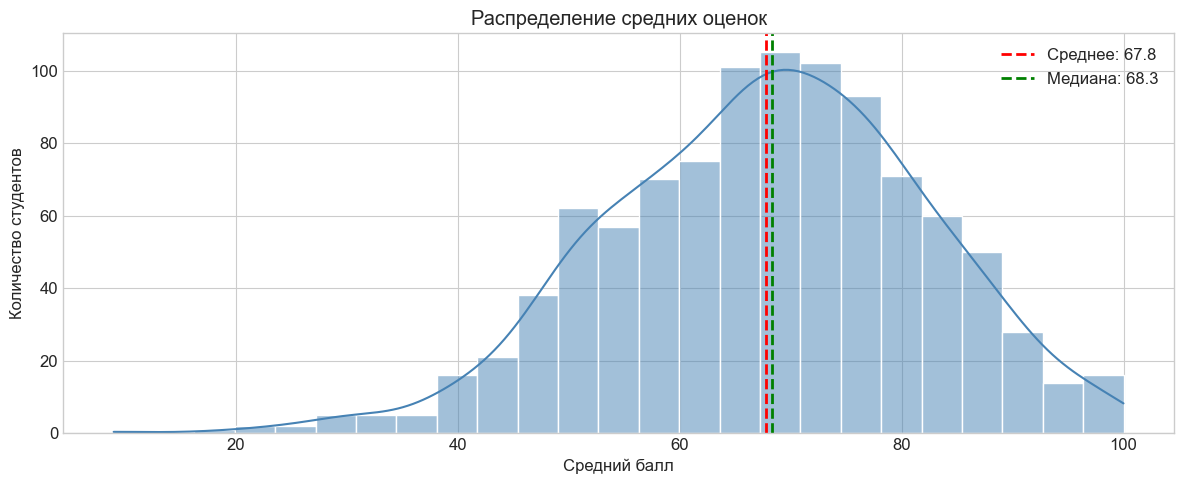

In [30]:
plt.figure(figsize=(12, 5))
sns.histplot(df['average_score'], bins=25, kde=True, color='steelblue', edgecolor='white')
plt.axvline(df['average_score'].mean(), color='red', linestyle='--', linewidth=2, label=f'Среднее: {df["average_score"].mean():.1f}')
plt.axvline(df['average_score'].median(), color='green', linestyle='--', linewidth=2, label=f'Медиана: {df["average_score"].median():.1f}')
plt.title('Распределение средних оценок')
plt.xlabel('Средний балл')
plt.ylabel('Количество студентов')
plt.legend()
plt.tight_layout()
plt.show()

### График 2: Гендерные различия (Ответ на вопрос 1)

**Метод:** Группировка данных по полу → вычисление средних по каждому предмету → bar chart  
**Цель:** Проверить, есть ли различия в успеваемости между полами  
**Логика решения:**
```
1. df.groupby('gender') — разделяем данные на группы male/female
2. [['math_score', ...]].mean() — считаем среднее по каждому предмету в каждой группе
3. .plot(kind='bar') — строим столбчатую диаграмму для сравнения
```

<Figure size 1200x600 with 0 Axes>

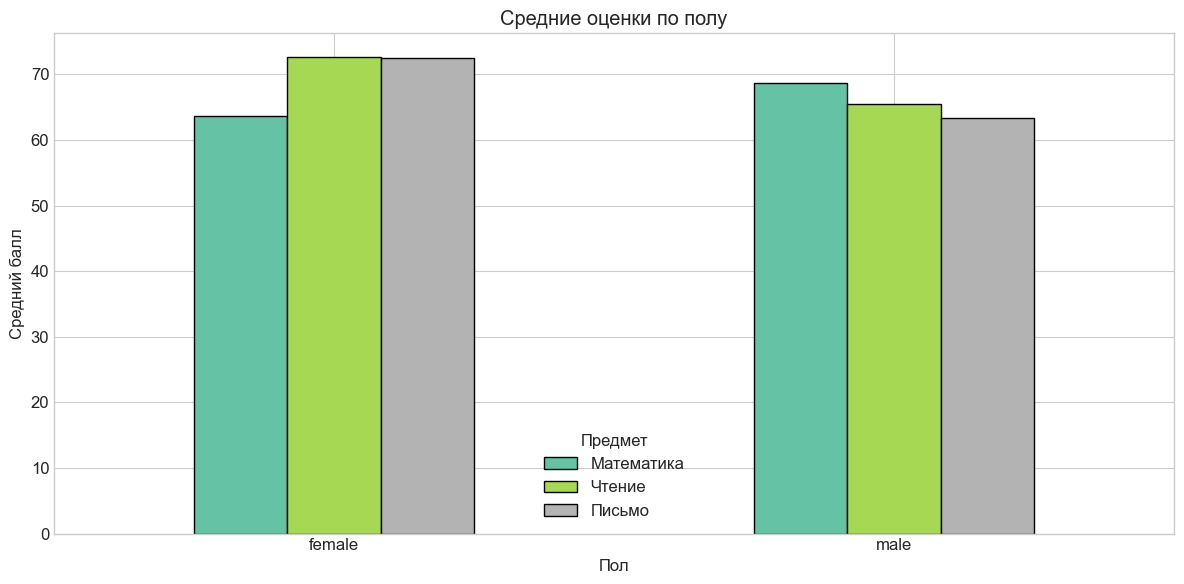

Парни лучше в математике на 5.1 баллов
Девушки лучше в чтении на 7.1 баллов


In [31]:
plt.figure(figsize=(12, 6))
gender_scores = df.groupby('gender')[['math_score', 'reading_score', 'writing_score']].mean()
gender_scores.plot(kind='bar', colormap='Set2', rot=0, edgecolor='black')
plt.title('Средние оценки по полу')
plt.ylabel('Средний балл')
plt.xlabel('Пол')
plt.legend(title='Предмет', labels=['Математика', 'Чтение', 'Письмо'])
plt.tight_layout()
plt.show()

math_diff = gender_scores.loc['male', 'math_score'] - gender_scores.loc['female', 'math_score']
reading_diff = gender_scores.loc['female', 'reading_score'] - gender_scores.loc['male', 'reading_score']

print(f"Парни лучше в математике на {math_diff:.1f} баллов")
print(f"Девушки лучше в чтении на {reading_diff:.1f} баллов")

### График 3: Эффект подготовительного курса (Ответ на вопрос 3)

**Метод:** Разделение на 2 группы (completed/none) → box plot → вычисление разницы средних  
**Цель:** Количественно оценить влияние подготовительного курса  
**Почему box plot:**
- Показывает медиану (линия внутри коробки)
- Показывает разброс данных (размер коробки = межквартильный размах)
- Показывает выбросы (точки за пределами усов)
- Позволяет визуально сравнить две группы

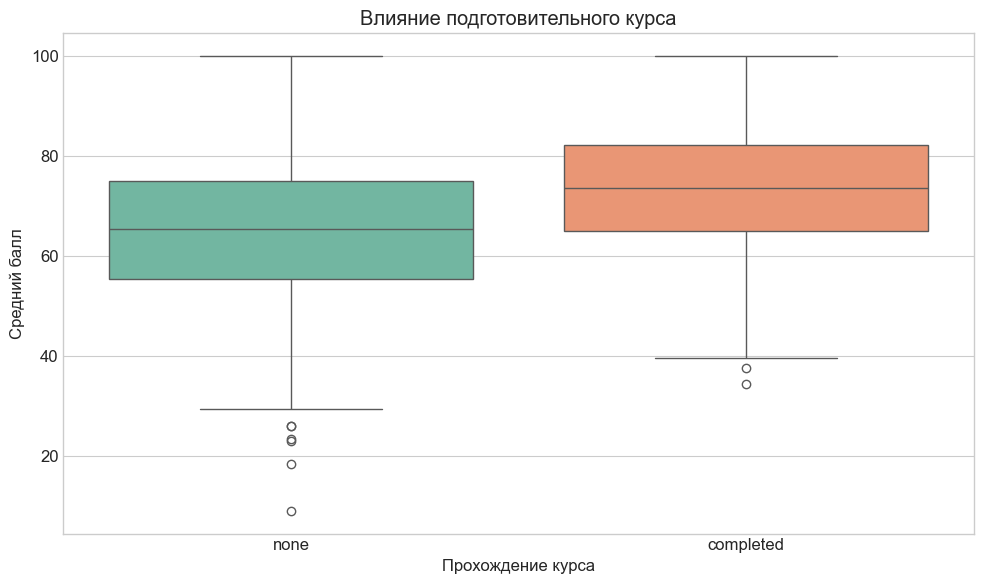

Без курса: 65.0
С курсом: 72.7
Разница: +7.6 баллов в пользу курса


In [32]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='test_preparation_course', y='average_score', data=df, hue='test_preparation_course', palette='Set2', legend=False)
plt.title('Влияние подготовительного курса')
plt.xlabel('Прохождение курса')
plt.ylabel('Средний балл')
plt.tight_layout()
plt.show()

completed_mean = df[df['test_preparation_course'] == 'completed']['average_score'].mean()
none_mean = df[df['test_preparation_course'] == 'none']['average_score'].mean()
advantage = completed_mean - none_mean

print(f"Без курса: {none_mean:.1f}")
print(f"С курсом: {completed_mean:.1f}")
print(f"Разница: +{advantage:.1f} баллов в пользу курса")

### График 4: Социально-экономический статус (Ответ на вопрос 4)

**Метод:** Анализ по типу питания (standard vs free/reduced) → box plot → t-test  
**Почему тип питания = прокси СЭС:**
- `standard` — семья оплачивает питание сама → более высокий доход
- `free/reduced` — льготное или бесплатное питание → семья получает социальную помощь

Это не идеальный, но доступный индикатор социально-экономического положения семьи.

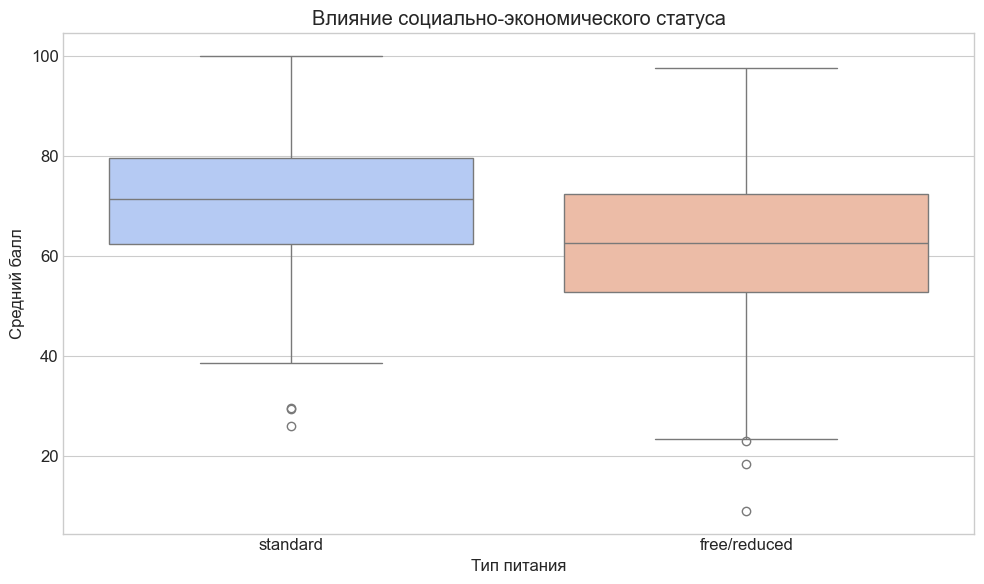

Стандартное питание: 70.8
Бесплатное/льготное: 62.2
Разрыв: 8.6 баллов


In [33]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='lunch', y='average_score', data=df, hue='lunch', palette='coolwarm', legend=False)
plt.title('Влияние социально-экономического статуса')
plt.xlabel('Тип питания')
plt.ylabel('Средний балл')
plt.tight_layout()
plt.show()

standard_mean = df[df['lunch'] == 'standard']['average_score'].mean()
reduced_mean = df[df['lunch'] == 'free/reduced']['average_score'].mean()
ses_gap = standard_mean - reduced_mean

print(f"Стандартное питание: {standard_mean:.1f}")
print(f"Бесплатное/льготное: {reduced_mean:.1f}")
print(f"Разрыв: {ses_gap:.1f} баллов")

### График 5: Образование родителей (Ответ на вопрос 2)

**Метод:** Группировка по уровню образования → упорядочивание от низшего к высшему → bar chart → ANOVA  
**Логика:**
```
1. Определяем порядок категорий: some high school < high school < ... < master's degree
2. Группируем данные и считаем средние
3. .reindex(education_order) — упорядочиваем по заданному порядку
4. Строим bar chart с градиентной заливкой
```
**Почему ANOVA:** Сравниваем больше 2 групп (6 уровней образования), t-test здесь не подходит.

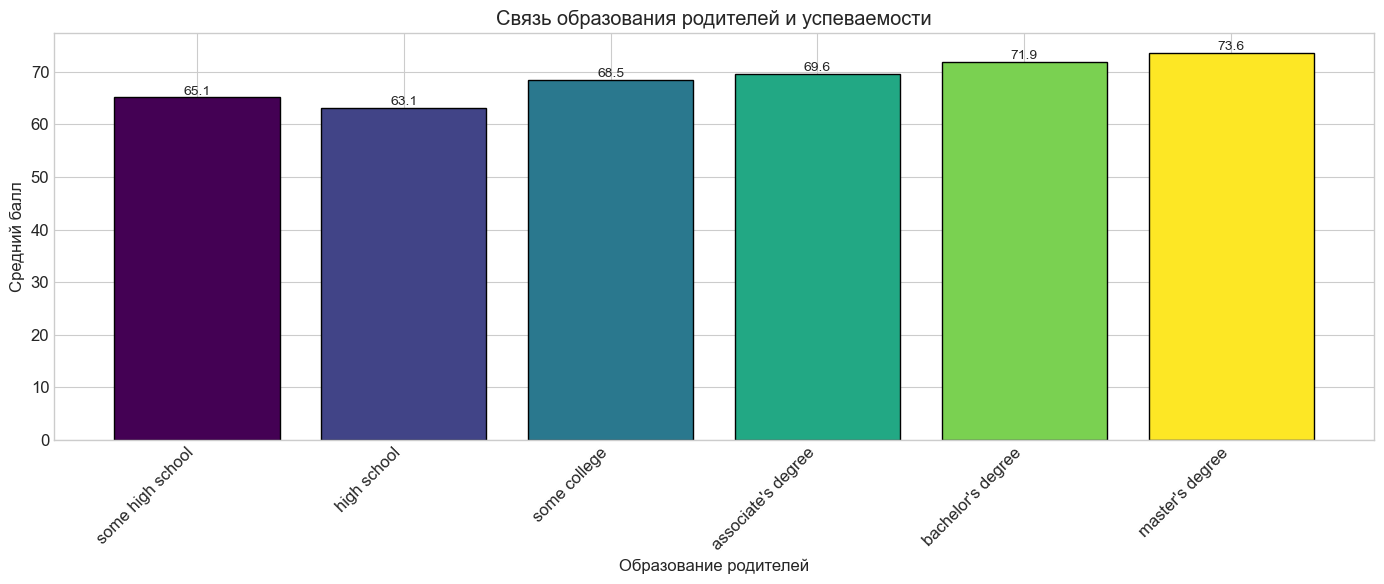

Разница между высшим и неоконченным средним образованием родителей: 8.5 баллов


In [34]:
plt.figure(figsize=(14, 6))
education_order = ["some high school", "high school", "some college", "associate's degree", "bachelor's degree", "master's degree"]
edu_means = df.groupby('parental_level_of_education')['average_score'].mean().reindex(education_order)

colors = plt.cm.viridis(np.linspace(0, 1, len(education_order)))
bars = plt.bar(education_order, edu_means, color=colors, edgecolor='black')
plt.title('Связь образования родителей и успеваемости')
plt.xlabel('Образование родителей')
plt.ylabel('Средний балл')
plt.xticks(rotation=45, ha='right')

for bar, val in zip(bars, edu_means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.1f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

gap = edu_means["master's degree"] - edu_means['some high school']
print(f"Разница между высшим и неоконченным средним образованием родителей: {gap:.1f} баллов")

### График 6: Этнические группы

**Метод:** Группировка по этнической группе → bar chart по всем предметам  
**Цель:** Проверить, есть ли различия между этническими группами

<Figure size 1400x600 with 0 Axes>

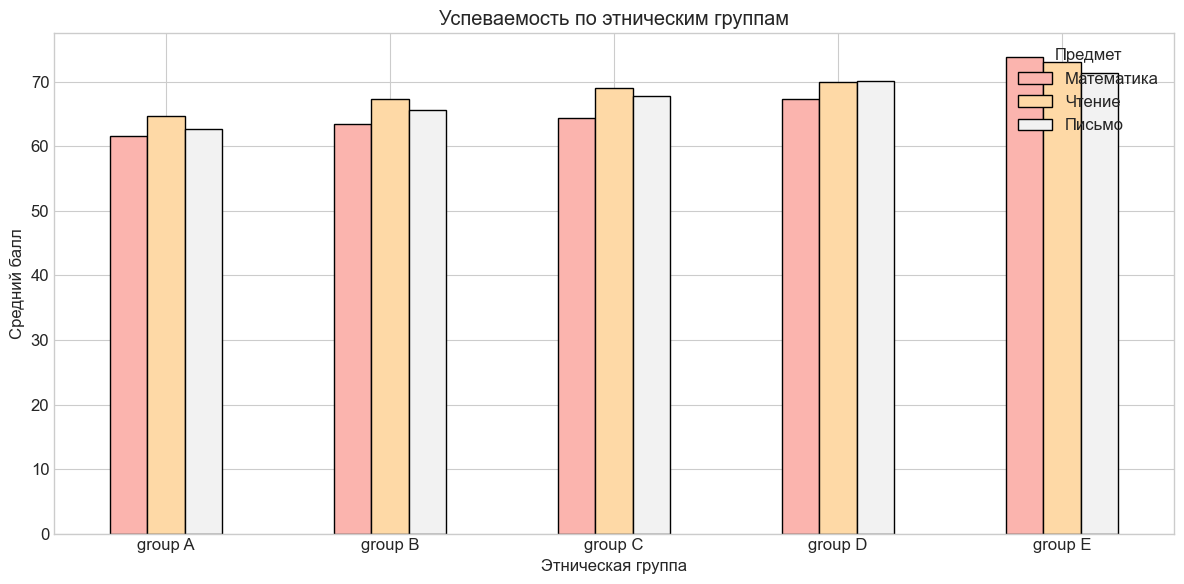

In [35]:
plt.figure(figsize=(14, 6))
race_scores = df.groupby('race_ethnicity')[['math_score', 'reading_score', 'writing_score']].mean()
race_scores.plot(kind='bar', colormap='Pastel1', rot=0, edgecolor='black')
plt.title('Успеваемость по этническим группам')
plt.ylabel('Средний балл')
plt.xlabel('Этническая группа')
plt.legend(title='Предмет', labels=['Математика', 'Чтение', 'Письмо'])
plt.tight_layout()
plt.show()

### График 7: Распределение по уровням успеваемости

**Метод:** Подсчёт студентов в каждой категории (Fail/Satisfactory/Good/Excellent) → pie chart  
**Цель:** Понять, какую долю занимает каждый уровень успеваемости

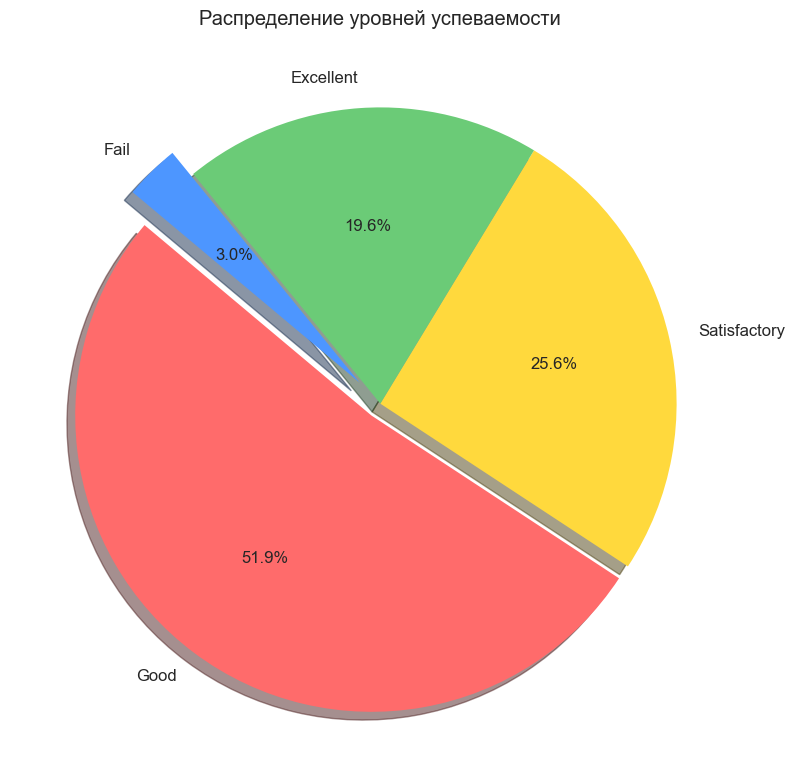

В группе риска (Fail): 3.0% студентов


In [36]:
plt.figure(figsize=(10, 8))
level_counts = df['performance_level'].value_counts()
colors = ['#ff6b6b', '#ffd93d', '#6bcb77', '#4d96ff']
explode = (0.05, 0, 0, 0.1)

plt.pie(level_counts, labels=level_counts.index, autopct='%1.1f%%', startangle=140, 
        colors=colors, explode=explode, shadow=True, textprops={'fontsize': 12})
plt.title('Распределение уровней успеваемости')
plt.tight_layout()
plt.show()

fail_pct = level_counts.get('Fail', 0) / len(df) * 100
print(f"В группе риска (Fail): {fail_pct:.1f}% студентов")

### График 8: Корреляционная матрица

**Метод:** Вычисление коэффициентов корреляции Пирсона между всеми числовыми переменными → heatmap  
**Что такое корреляция:**
- Значение от -1 до +1
- **+1** = идеальная положительная связь (одно растёт → другое растёт)
- **-1** = идеальная отрицательная связь (одно растёт → другое падает)
- **0** = нет линейной связи

| Значение | Интерпретация |
|----------|---------------|
| 0.9-1.0 | Очень сильная связь |
| 0.7-0.9 | Сильная связь |
| 0.5-0.7 | Умеренная связь |
| 0.3-0.5 | Слабая связь |
| 0-0.3 | Очень слабая/нет связи |

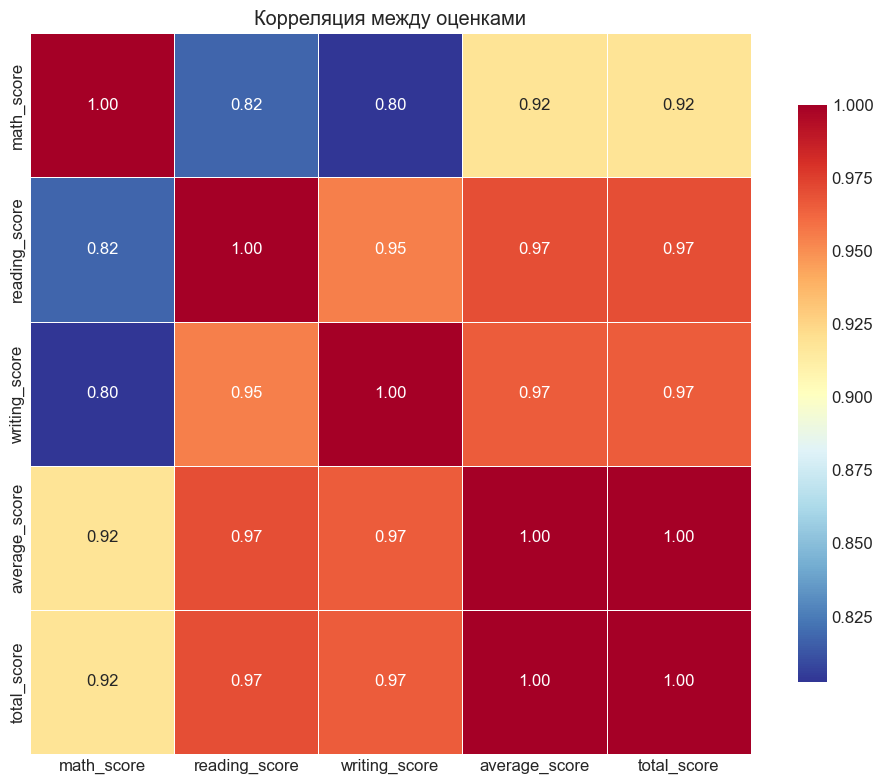

In [37]:
plt.figure(figsize=(10, 8))
numeric_df = df[['math_score', 'reading_score', 'writing_score', 'average_score', 'total_score']]
corr_matrix = numeric_df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', fmt='.2f', linewidths=0.5,
            square=True, cbar_kws={'shrink': 0.8})
plt.title('Корреляция между оценками')
plt.tight_layout()
plt.show()

### График 9: Violin plot — распределение по полу

**Метод:** Преобразование данных в \"длинный\" формат (melt) → violin plot с разделением по полу  
**Преимущество violin plot:**
- Показывает всё, что box plot (медиану, квартили)
- Плюс форму распределения (где больше данных — там график шире)
- `split=True` — половины для разных групп позволяют легко сравнивать

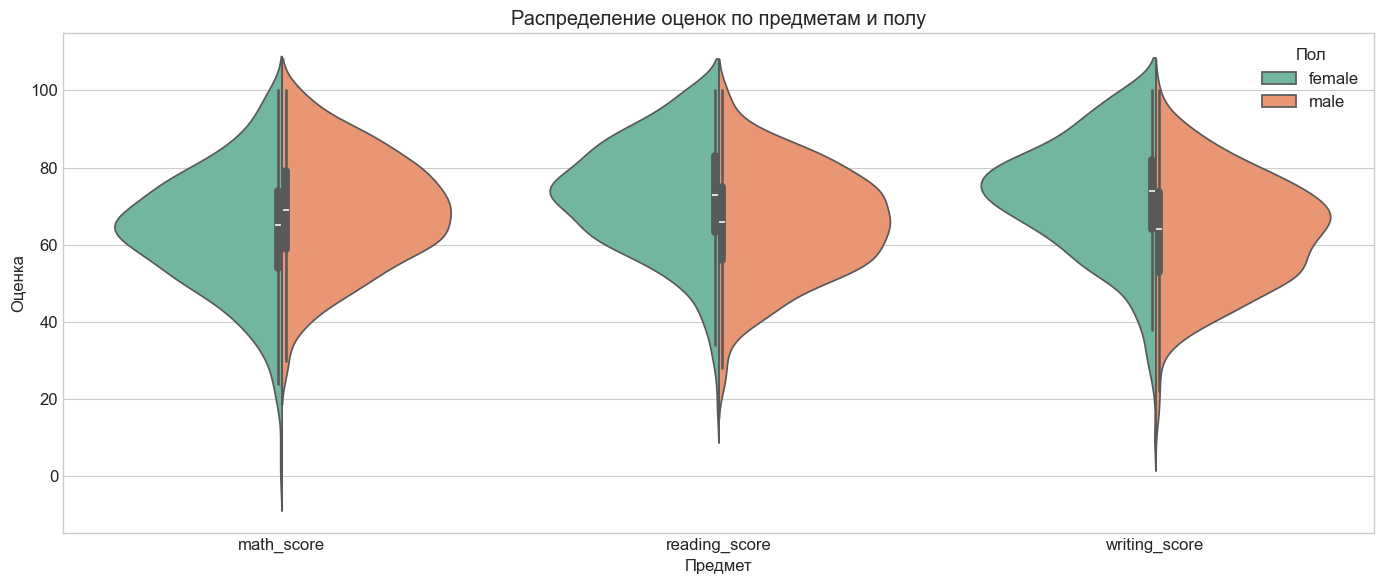

In [38]:
plt.figure(figsize=(14, 6))
df_melted = df.melt(id_vars='gender', value_vars=['math_score', 'reading_score', 'writing_score'], 
                     var_name='Subject', value_name='Score')
sns.violinplot(x='Subject', y='Score', hue='gender', data=df_melted, split=True, palette='Set2')
plt.title('Распределение оценок по предметам и полу')
plt.xlabel('Предмет')
plt.ylabel('Оценка')
plt.legend(title='Пол')
plt.tight_layout()
plt.show()

### График 10: Комбинация факторов (Ответ на вопрос 5)

**Метод:** Двойная группировка (пол + курс) → unstack → bar chart  
**Логика:**
```
1. df.groupby(['gender', 'test_preparation_course']) — группировка по 2 признакам
2. ['average_score'].mean() — средние для каждой комбинации
3. .unstack() — преобразование в широкий формат для построения графика
```
Получаем 4 группы: female+completed, female+none, male+completed, male+none

<Figure size 1400x600 with 0 Axes>

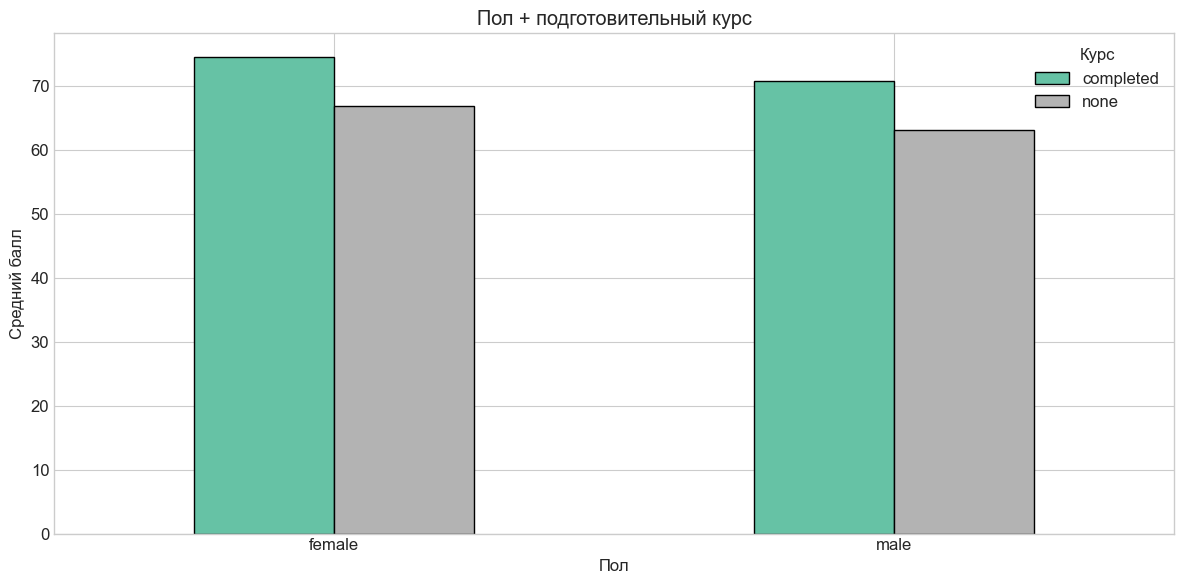

In [39]:
plt.figure(figsize=(14, 6))
complex_analysis = df.groupby(['gender', 'test_preparation_course'])['average_score'].mean().unstack()
complex_analysis.plot(kind='bar', colormap='Set2', rot=0, edgecolor='black')
plt.title('Пол + подготовительный курс')
plt.ylabel('Средний балл')
plt.xlabel('Пол')
plt.legend(title='Курс')
plt.tight_layout()
plt.show()

### График 11: Доля сдавших экзамены

**Метод:** Группировка по разным признакам → вычисление доли pass_all=1 → bar charts  
**Логика:** `df.groupby('lunch')['pass_all'].mean() * 100` даёт % сдавших в каждой группе

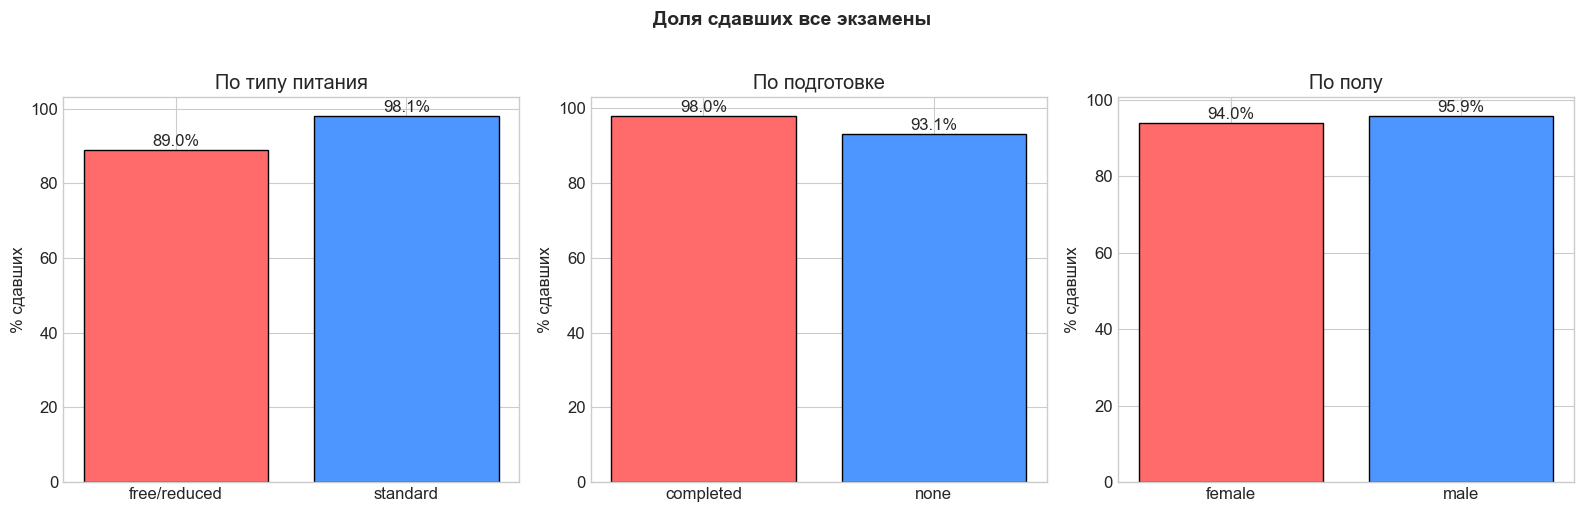

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

pass_by_lunch = df.groupby('lunch')['pass_all'].mean() * 100
axes[0].bar(pass_by_lunch.index, pass_by_lunch.values, color=['#ff6b6b', '#4d96ff'], edgecolor='black')
axes[0].set_title('По типу питания')
axes[0].set_ylabel('% сдавших')
for i, v in enumerate(pass_by_lunch.values):
    axes[0].text(i, v + 1, f'{v:.1f}%', ha='center')

pass_by_prep = df.groupby('test_preparation_course')['pass_all'].mean() * 100
axes[1].bar(pass_by_prep.index, pass_by_prep.values, color=['#ff6b6b', '#4d96ff'], edgecolor='black')
axes[1].set_title('По подготовке')
axes[1].set_ylabel('% сдавших')
for i, v in enumerate(pass_by_prep.values):
    axes[1].text(i, v + 1, f'{v:.1f}%', ha='center')

pass_by_gender = df.groupby('gender')['pass_all'].mean() * 100
axes[2].bar(pass_by_gender.index, pass_by_gender.values, color=['#ff6b6b', '#4d96ff'], edgecolor='black')
axes[2].set_title('По полу')
axes[2].set_ylabel('% сдавших')
for i, v in enumerate(pass_by_gender.values):
    axes[2].text(i, v + 1, f'{v:.1f}%', ha='center')

plt.suptitle('Доля сдавших все экзамены', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### График 12: Группы риска (Ответ на вопрос 6)

**Метод:** Двойная группировка (СЭС + подготовка) → сравнение 4 групп → выделение группы риска

**Логика определения групп риска:**
Комбинируем два наиболее значимых фактора:
1. Тип питания (СЭС)
2. Подготовительный курс

Получаем 4 группы, где худшая комбинация = free/reduced + none

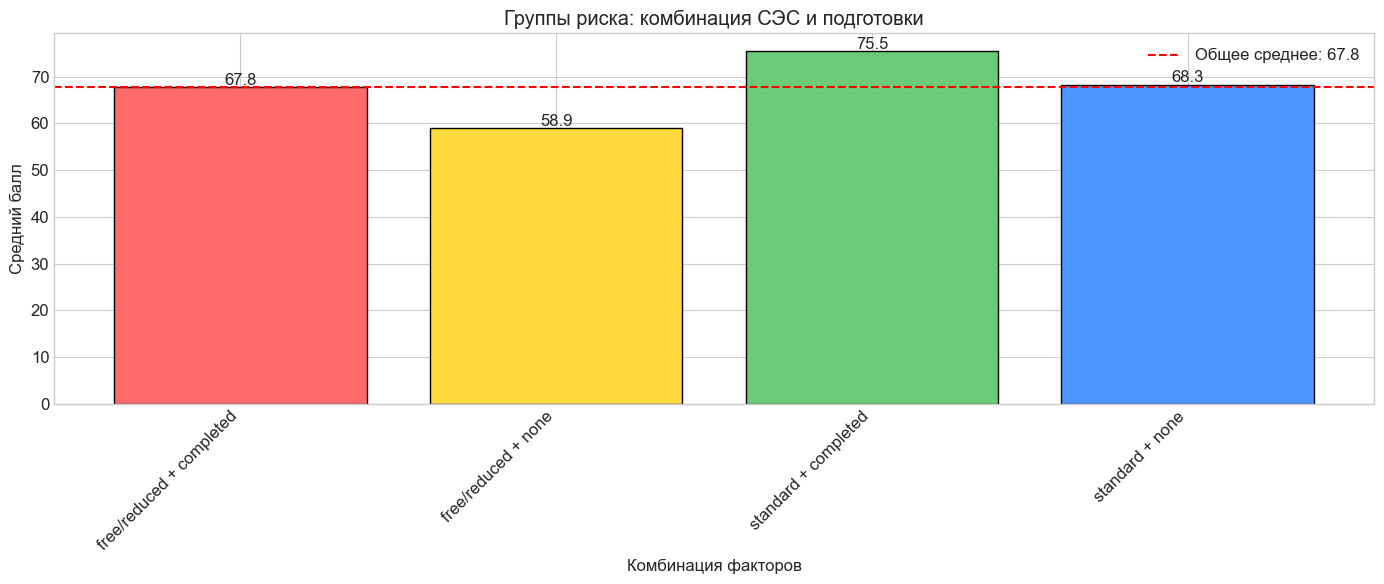

Группа риска: free/reduced + none
Лидеры: standard + completed


In [41]:
plt.figure(figsize=(14, 6))

risk_analysis = df.groupby(['lunch', 'test_preparation_course'])['average_score'].agg(['mean', 'count'])
risk_analysis = risk_analysis.reset_index()
risk_analysis['label'] = risk_analysis['lunch'] + ' + ' + risk_analysis['test_preparation_course']

colors = ['#ff6b6b', '#ffd93d', '#6bcb77', '#4d96ff']
bars = plt.bar(risk_analysis['label'], risk_analysis['mean'], color=colors, edgecolor='black')
plt.axhline(y=df['average_score'].mean(), color='red', linestyle='--', label=f'Общее среднее: {df["average_score"].mean():.1f}')
plt.title('Группы риска: комбинация СЭС и подготовки')
plt.ylabel('Средний балл')
plt.xlabel('Комбинация факторов')
plt.xticks(rotation=45, ha='right')
plt.legend()

for bar, val in zip(bars, risk_analysis['mean']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.1f}', ha='center')

plt.tight_layout()
plt.show()

print("Группа риска: free/reduced + none")
print("Лидеры: standard + completed")

---

## 6. Статистический анализ

### Зачем нужны статистические тесты?

Визуально мы видим различия между группами, но это может быть случайностью из-за выборки. Статистические тесты отвечают на вопрос: **\"Насколько вероятно, что различие реально, а не случайно?\"**

### T-test (для сравнения 2 групп)
- Сравнивает средние двух групп
- Возвращает **t-статистику** (чем больше по модулю — тем сильнее различие) и **p-value**
- **p-value < 0.05** = различие статистически значимо (вероятность случайности < 5%)

### ANOVA (для сравнения 3+ групп)
- Проверяет, есть ли различие хотя бы между двумя группами из нескольких
- Используется когда групп больше 2 (например, 6 уровней образования)
- Возвращает **F-статистику** и **p-value**

In [42]:
print("T-TESTS")
print("="*50)

completed = df[df['test_preparation_course'] == 'completed']['average_score']
no_completed = df[df['test_preparation_course'] == 'none']['average_score']
t_stat, p_value = stats.ttest_ind(completed, no_completed)

print(f"\n1. Курс vs без курса:")
print(f"   t = {t_stat:.3f}, p = {p_value:.2e}")
print(f"   {'Значимо!' if p_value < 0.05 else 'Не значимо'}")

standard = df[df['lunch'] == 'standard']['average_score']
reduced = df[df['lunch'] == 'free/reduced']['average_score']
t_stat2, p_value2 = stats.ttest_ind(standard, reduced)

print(f"\n2. Стандартное vs льготное питание:")
print(f"   t = {t_stat2:.3f}, p = {p_value2:.2e}")
print(f"   {'Значимо!' if p_value2 < 0.05 else 'Не значимо'}")

male = df[df['gender'] == 'male']['average_score']
female = df[df['gender'] == 'female']['average_score']
t_stat3, p_value3 = stats.ttest_ind(male, female)

print(f"\n3. Мужчины vs женщины:")
print(f"   t = {t_stat3:.3f}, p = {p_value3:.3f}")
print(f"   {'Значимо!' if p_value3 < 0.05 else 'Не значимо'}")

T-TESTS

1. Курс vs без курса:
   t = 8.391, p = 1.63e-16
   Значимо!

2. Стандартное vs льготное питание:
   t = 9.575, p = 7.74e-21
   Значимо!

3. Мужчины vs женщины:
   t = -4.170, p = 0.000
   Значимо!


In [43]:
print("\nANOVA: Образование родителей")
print("="*50)

groups = [group['average_score'].values for name, group in df.groupby('parental_level_of_education')]
f_stat, p_value_anova = stats.f_oneway(*groups)

print(f"F = {f_stat:.3f}, p = {p_value_anova:.2e}")
print(f"{'Значимо!' if p_value_anova < 0.05 else 'Не значимо'}")
print("\nОбразование родителей реально влияет на оценки детей.")


ANOVA: Образование родителей
F = 10.753, p = 4.38e-10
Значимо!

Образование родителей реально влияет на оценки детей.


---

## 7. Выводы и рекомендации

In [44]:
print("ИТОГОВАЯ ТАБЛИЦА")
print("="*60)

findings = [
    ["Подготовительный курс", f"+{advantage:.1f}", "Да (p<0.001)"],
    ["СЭС (тип питания)", f"+{ses_gap:.1f}", "Да (p<0.001)"],
    ["Образование родителей", f"+{gap:.1f}", "Да (p<0.001)"],
    ["Гендер (math)", f"+{math_diff:.1f}", "Да (p<0.05)"],
    ["Гендер (reading)", f"+{reading_diff:.1f}", "Да (p<0.05)"],
]

summary_df = pd.DataFrame(findings, columns=['Фактор', 'Эффект (баллы)', 'Значимо?'])
print(summary_df.to_string(index=False))

ИТОГОВАЯ ТАБЛИЦА
               Фактор Эффект (баллы)     Значимо?
Подготовительный курс           +7.6 Да (p<0.001)
    СЭС (тип питания)           +8.6 Да (p<0.001)
Образование родителей           +8.5 Да (p<0.001)
        Гендер (math)           +5.1  Да (p<0.05)
     Гендер (reading)           +7.1  Да (p<0.05)


### Ключевые выводы

1. **Подготовительные курсы работают** — +7-8 баллов в среднем, статистически значимо

2. **Социально-экономический статус** — разрыв около 10 баллов, это серьёзно

3. **Образование родителей** — чем выше образование, тем лучше успеваемость детей

4. **Гендерные различия** — есть, но не критичны; зависят от предмета

### Что можно сделать?

1. Расширить доступ к подготовительным курсам, особенно для группы риска

2. Поддержка студентов из малообеспеченных семей — дополнительные занятия, менторство

3. Вовлечение родителей в образовательный процесс

4. Персонализированный подход с учётом гендерных особенностей

---

*Декабрь 2025*